In [13]:
%%bash

pip install -q pandas==0.23.0
pip install -q numpy==1.14.3
pip install -q matplotlib==3.0.3
pip install -q seaborn==0.8.1
pip install -q PyAthena==1.8.0

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.sparse import lil_matrix

import boto3
import botocore
import sagemaker

In [3]:
session = boto3.session.Session()
region_name = session.region_name

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

## Data Preparation

### Create New Table with Sentiment
We no longer need a separate table.

This will be used by the model training.

This following query takes a long time (approx. 5min / scanning 50GB).
Find the equivalent in the sql/ directory and run within Athena Console.

**[TODO] Show screenshot of Athena console where to put in the query with link to github sql statement**

In [4]:
from pyathena import connect
from pyathena.util import as_pandas

database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'
sentiment_table_name = 'amazon_reviews_with_sentiment'
table_prefix = 'amazon_reviews_with_sentiment'

s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

In [5]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
try:
    cursor.execute('CREATE TABLE IF NOT EXISTS {} \
                WITH ( \
                  format = \'PARQUET\', \
                  external_location = \'s3://{}/{}/\', \
                      partitioned_by = ARRAY[\'product_category\'] \
                ) \
                AS \
                SELECT customer_id, \
                         review_id, \
                         product_id, \
                         product_title, \
                         review_headline, \
                         review_body, \
                         review_date, \
                         year, \
                         star_rating, \
                         CASE \
                             WHEN star_rating > 3 THEN 1 \
                             ELSE 0 \
                         END AS sentiment, \
                         product_category \
                FROM {}.{} \
                WHERE LENGTH(review_body) > 20'
               .format(sentiment_table_name, bucket, table_prefix, database_name, table_name))
except:
    pass
 

### View Sentiment

This following query takes a long time... find the equivalent in the sql/ directory and run within Athena Console.

In [17]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT customer_id, \
                         review_id, \
                         product_id, \
                         product_title, \
                         review_headline, \
                         review_body, \
                         review_date, \
                         year, \
                         star_rating, \
                         sentiment, \
                         product_category \
                FROM {}.{} \
                WHERE product_category = \'Digital_Video_Download\' \
                ORDER BY review_id \
                LIMIT 500'
               .format(database_name, sentiment_table_name))
df = as_pandas(cursor)

In [18]:
df.head(5)

,customer_id,review_id,product_id,product_title,review_headline,review_body,review_date,year,star_rating,sentiment,product_category
0,34517685,R10001EP8WFB6B,B007FUI0DC,Jericho Season 1,Molasses,Good potential but Wow the story d evelops so ...,15774,2013,1,0,Digital_Video_Download
1,43069393,R10003S70PHM13,B005U9RM0W,Grimm Season 1,Grimm,It's a little campie. Fun to watch no to grose...,16135,2014,4,1,Digital_Video_Download
2,51158649,R10007TUBYKPHE,B00KF7OOIW,True Detective: Season 1,Extremely well done police procedural,"Excellent acting, excellent story line, excell...",16271,2014,5,1,Digital_Video_Download
3,51158649,R10007TUBYKPHE,B00KF7OOIW,True Detective: Season 1,Extremely well done police procedural,"Excellent acting, excellent story line, excell...",16271,2014,5,1,Digital_Video_Download
4,50354349,R100093J2OR25M,B009CPE4TM,Thomas & Friends: Blue Mountain Mystery The Movie,Sam Loves It!,This is Sam's (3 yr old) absolute favorite Tho...,16531,2015,5,1,Digital_Video_Download


1    381
0    119
Name: sentiment, dtype: int64


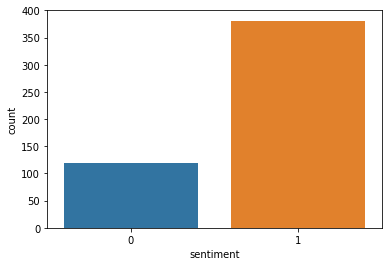

In [19]:
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)

### Handling imbalanced datasets

Here you can see we have a larger number of `positive` samples vs. `negative` ones. There are a number of techniques to blance this dataset out and the two most popular approaches are to either under-sample or over-sample. With under sampling you remove rows to balance the dataset out and in over sampling you can duplicate entries in the daatset which could lead to overfitting. This discussion is beyond the scope of this lab. You will under sample the data to balance the dataset but you can find more information [here]().

1    119
0    119
Name: sentiment, dtype: int64


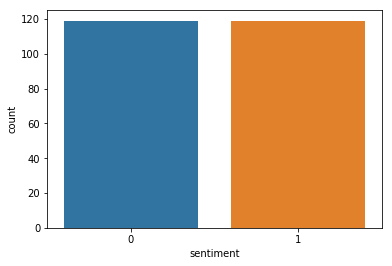

In [23]:
from sklearn.utils import resample

positive = df[df['sentiment']==1]
negative = df[df['sentiment']==0]

positive_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
df = pd.concat([positive_downsampled, negative])

# checking counts
print(df['sentiment'].value_counts())

sns.countplot(x='sentiment', data=df)

### Create Test, Train, and Validation Datasets

Depending on the framework you are leveraging in your AI/ML workloads you may decide to split the data into test, train, and validate splits before uploading to S3. You can leverage some built in functions in the sklearn package to do the split. To learn more about the sklearn framework click [here](https://scikit-learn.org/stable/).

In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=0)
test, validate = train_test_split(test, test_size=0.5, random_state=0)

print(f'Number of training examples: {len(train.index)}')
print(f'Number of testing examples: {len(test.index)}')
print(f'Number of validation examples: {len(validate.index)}')


Number of training examples: 190
Number of testing examples: 24
Number of validation examples: 24


### Visualize the Train, Test, and Validation Split

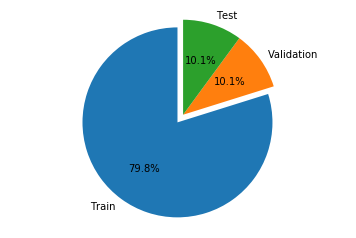

In [25]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Train', 'Validation', 'Test']
sizes = [len(train.index), len(validate.index), len(test.index)]
explode = (0.1, 0, 0)  

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  

plt.show()

In [7]:
# df = df[['customer_id', 'product_id', 'product_title', 'star_rating', 'review_date']]

In [8]:
# df.head(5)

,customer_id,product_id,product_title,star_rating,review_date
0,34517685,B007FUI0DC,Jericho Season 1,1,15774
1,43069393,B005U9RM0W,Grimm Season 1,4,16135
2,51158649,B00KF7OOIW,True Detective: Season 1,5,16271
3,51158649,B00KF7OOIW,True Detective: Season 1,5,16271
4,50354349,B009CPE4TM,Thomas & Friends: Blue Mountain Mystery The Movie,5,16531


In [9]:
# df.shape

(500, 5)

In [26]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

num_customers = customers.count()
print(num_customers)
num_products = products.count()
print(num_products)
num_features = num_customers + num_products
print(num_features)

211
208
419


TODO:  Filter out customers who haven't rated many movies

In [27]:
#customers = customers[customers >= 5]
#products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))
reduced_df

,customer_id,review_id,product_id,product_title,review_headline,review_body,review_date,year,star_rating,sentiment,product_category
0,34431985,R1006QFBOEMHNM,B008602KQI,The Hunger Games,Great watch,Can't wait for the sequel. Loved the movie but...,15951,2013,5,1,Digital_Video_Download
1,34431985,R1006QFBOEMHNM,B008602KQI,The Hunger Games,Great watch,Can't wait for the sequel. Loved the movie but...,15951,2013,5,1,Digital_Video_Download
2,50354349,R100093J2OR25M,B009CPE4TM,Thomas & Friends: Blue Mountain Mystery The Movie,Sam Loves It!,This is Sam's (3 yr old) absolute favorite Tho...,16531,2015,5,1,Digital_Video_Download
3,47656319,R1002R2R6KE8L9,B009TGWVRG,The Last Legion,Four Stars,Awesome!,16550,2015,4,1,Digital_Video_Download
4,17741267,R1002EQU1QPYCW,B006MW3UZW,Downton Abbey Season 2,Entertaining,Love the stories love the characters and of co...,15844,2013,5,1,Digital_Video_Download
5,30327264,R100F3KJLE4490,B0095R3J8O,Parenthood Season 4,Best show ever!,This show is one of my favorite shows ever. I ...,16039,2013,5,1,Digital_Video_Download
6,32481204,R1000WECL308AA,B002APU580,Pride & Prejudice,Five Stars,One of the best movies I've ever seen,16604,2015,5,1,Digital_Video_Download
7,32481204,R1000WECL308AA,B002APU580,Pride & Prejudice,Five Stars,One of the best movies I've ever seen,16604,2015,5,1,Digital_Video_Download
8,43732106,R1004HSUBW8N9J,B009FINAJG,Red Scorpion,I like Dolf Lundgren movies and this is a pret...,"What, I like Dolf Lundgren movies and this is ...",16494,2015,4,1,Digital_Video_Download
9,50254309,R100B2JSJ88I0N,B00J8CG6KE,Wolf Of Wall Street,Adults only,I was a put off by the continous bad langage i...,16174,2014,4,1,Digital_Video_Download


Create a sequential index for customers and movies

In [12]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

#customers = df['customer_id'].value_counts()
#products = df['product_id'].value_counts()

print(customers)
print(products)

5291529     3
36509441    2
30608149    2
43732106    2
52158328    2
47293627    2
17137405    2
48596676    2
6686734     2
36977882    2
12558980    2
33559760    2
24380338    2
13441340    2
28149345    2
14275711    2
14746252    2
37345187    2
45441257    2
50604439    2
4087170     2
20347036    2
32852153    2
47969705    2
25577329    2
18314288    2
50519187    2
18917224    2
10603872    2
48029101    2
           ..
10845791    1
5822384     1
40451857    1
17051537    1
26964015    1
51131758    1
12261193    1
50919495    1
43531080    1
52887877    1
16785420    1
49158878    1
20675305    1
12892245    1
46506449    1
13502593    1
10709236    1
2458036     1
27208165    1
14524096    1
13059290    1
12769609    1
22880068    1
30322022    1
6595937     1
53063551    1
52782123    1
21731632    1
49358042    1
49258403    1
Name: customer_id, Length: 400, dtype: int64
B00J8CG6KE    6
B00BVYNSLC    4
B000YMM3CC    4
B008602KQI    4
B00I3MQNWG    3
B00HYTLY64    2
B00KF

Preserve the index for later use

## Balancing dataset
[TODO] add this here

In [15]:
customer_index = pd.DataFrame({'customer_id': customers.index, 
                               'user': np.arange(customers.shape[0])})
print(customer_index.shape)

product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0]) + customer_index.shape[0]})
print(product_index.shape)

(328, 2)
(309, 2)


In [16]:
reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,product_title,star_rating,review_date,user,item
0,48685922,B000ICXQVA,Halloween III: Season of the Witch,2,11234,129,461
1,45764909,B001II0M9W,Simply Irresistible,3,11485,4,508
2,45764909,B00QFNLJZQ,A.I. Artificial Intelligence,4,11755,4,384
3,45764909,B00QFNLJZQ,A.I. Artificial Intelligence,4,11755,4,384
4,45764909,B009941RI2,Wuthering Heights,5,11781,4,586


Count days since first review (included as a feature to capture trend)

In [17]:
reduced_df['review_date'] = pd.to_datetime(reduced_df['review_date'])
customer_first_date = reduced_df.groupby('customer_id')['review_date'].min().reset_index()
customer_first_date.columns = ['customer_id', 'first_review_date']

In [18]:
reduced_df = reduced_df.merge(customer_first_date)
reduced_df['days_since_first'] = (reduced_df['review_date'] - reduced_df['first_review_date']).dt.days
reduced_df['days_since_first'] = reduced_df['days_since_first'].fillna(0)

Split into train and test datasets

In [19]:
train_df = reduced_df.groupby('customer_id').last().reset_index()
train_df

,customer_id,product_id,product_title,star_rating,review_date,user,item,first_review_date,days_since_first
0,10046247,B000H4XMPY,Firefly,4,1970-01-01 00:00:00.000013429,214,332,1970-01-01 00:00:00.000013429,0
1,10211810,B000MKIIKC,League of Gentlemen,5,1970-01-01 00:00:00.000013567,273,558,1970-01-01 00:00:00.000013567,0
2,10213381,B000H0ZSWI,Comedy Central Presents,4,1970-01-01 00:00:00.000013397,58,549,1970-01-01 00:00:00.000013390,0
3,10310560,B000IVB07S,Studio 60 on the Sunset Strip,5,1970-01-01 00:00:00.000013497,209,333,1970-01-01 00:00:00.000013497,0
4,10376605,B000MDHL5M,The Awful Truth,5,1970-01-01 00:00:00.000013548,145,472,1970-01-01 00:00:00.000013548,0
5,10653514,B000H1H1KO,Matching Escort,5,1970-01-01 00:00:00.000013475,240,451,1970-01-01 00:00:00.000013475,0
6,10689774,B000HKYBXA,Hamlet (1996),4,1970-01-01 00:00:00.000013497,68,422,1970-01-01 00:00:00.000013497,0
7,10720609,B000H22NK6,Chappelle's Show,1,1970-01-01 00:00:00.000013442,231,512,1970-01-01 00:00:00.000013442,0
8,11080643,B000M2SM92,Little Miss Sunshine,5,1970-01-01 00:00:00.000013541,78,395,1970-01-01 00:00:00.000013541,0
9,11129489,B000IB4MXW,Jonathan Livingston Seagull,1,1970-01-01 00:00:00.000013499,281,381,1970-01-01 00:00:00.000013499,0


In [20]:
test_df = reduced_df.merge(train_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
test_df = test_df[(test_df['_merge'] == 'left_only')]
test_df

,customer_id,product_id,product_title,star_rating,review_date,user,item,first_review_date,days_since_first,_merge
1,45764909,B001II0M9W,Simply Irresistible,3,1970-01-01 00:00:00.000011485,4,508,1970-01-01 00:00:00.000011485,0,left_only
2,45764909,B00QFNLJZQ,A.I. Artificial Intelligence,4,1970-01-01 00:00:00.000011755,4,384,1970-01-01 00:00:00.000011485,0,left_only
3,45764909,B00QFNLJZQ,A.I. Artificial Intelligence,4,1970-01-01 00:00:00.000011755,4,384,1970-01-01 00:00:00.000011485,0,left_only
4,45764909,B009941RI2,Wuthering Heights,5,1970-01-01 00:00:00.000011781,4,586,1970-01-01 00:00:00.000011485,0,left_only
5,45764909,B007C86CDW,Radio Flyer,4,1970-01-01 00:00:00.000012306,4,564,1970-01-01 00:00:00.000011485,0,left_only
21,52824002,B001JIFYSA,Love Actually,5,1970-01-01 00:00:00.000012750,9,393,1970-01-01 00:00:00.000012750,0,left_only
22,52824002,B001JIFYSA,Love Actually,5,1970-01-01 00:00:00.000012750,9,393,1970-01-01 00:00:00.000012750,0,left_only
26,48652051,B0014D6PCO,Batman Begins,5,1970-01-01 00:00:00.000012956,0,407,1970-01-01 00:00:00.000012956,0,left_only
27,48652051,B0014D6PCO,Batman Begins,5,1970-01-01 00:00:00.000012956,0,407,1970-01-01 00:00:00.000012956,0,left_only
28,48652051,B000ICK816,George A. Romero's Land of the Dead,3,1970-01-01 00:00:00.000012963,0,591,1970-01-01 00:00:00.000012956,0,left_only


- Factorization machines expects data to look something like:
  - Sparse matrix
  - Target variable is that user's rating for a movie
  - One-hot encoding for users ($N$ features)
  - One-hot encoding for movies ($M$ features)

|Rating|User1|User2|...|UserN|Movie1|Movie2|Movie3|...|MovieM|Feature1|Feature2|...|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|4|1|0|...|0|1|0|0|...|0|20|2.2|...|
|5|1|0|...|0|0|1|0|...|0|17|9.1|...|
|3|0|1|...|0|1|0|0|...|0|3|11.0|...|
|4|0|1|...|0|0|0|1|...|0|15|6.4|...|

In [21]:
from scipy.sparse import csr_matrix

def to_csr_matrix(df, num_users, num_items):
    feature_dim = num_users + num_items + 1
    data = np.concatenate([np.array([1] * df.shape[0]),
                           np.array([1] * df.shape[0]),
                           df['days_since_first'].values])
    row = np.concatenate([np.arange(df.shape[0])] * 3)
    col = np.concatenate([df['user'].values,
                          df['item'].values,
                          np.array([feature_dim - 1] * df.shape[0])])
    return csr_matrix((data, (row, col)), 
                      shape=(df.shape[0], feature_dim), 
                      dtype=np.float32)

In [22]:
train_csr = to_csr_matrix(train_df, customer_index.shape[0], product_index.shape[0])
print(train_csr)

  (0, 214)	1.0
  (0, 332)	1.0
  (0, 637)	0.0
  (1, 273)	1.0
  (1, 558)	1.0
  (1, 637)	0.0
  (2, 58)	1.0
  (2, 549)	1.0
  (2, 637)	0.0
  (3, 209)	1.0
  (3, 333)	1.0
  (3, 637)	0.0
  (4, 145)	1.0
  (4, 472)	1.0
  (4, 637)	0.0
  (5, 240)	1.0
  (5, 451)	1.0
  (5, 637)	0.0
  (6, 68)	1.0
  (6, 422)	1.0
  (6, 637)	0.0
  (7, 231)	1.0
  (7, 512)	1.0
  (7, 637)	0.0
  (8, 78)	1.0
  :	:
  (319, 637)	0.0
  (320, 208)	1.0
  (320, 561)	1.0
  (320, 637)	0.0
  (321, 5)	1.0
  (321, 385)	1.0
  (321, 637)	0.0
  (322, 8)	1.0
  (322, 450)	1.0
  (322, 637)	0.0
  (323, 213)	1.0
  (323, 534)	1.0
  (323, 637)	0.0
  (324, 65)	1.0
  (324, 404)	1.0
  (324, 637)	0.0
  (325, 264)	1.0
  (325, 557)	1.0
  (325, 637)	0.0
  (326, 89)	1.0
  (326, 425)	1.0
  (326, 637)	0.0
  (327, 57)	1.0
  (327, 426)	1.0
  (327, 637)	0.0


In [23]:
test_csr = to_csr_matrix(test_df, customer_index.shape[0], product_index.shape[0])
print(test_csr)

  (0, 4)	1.0
  (0, 508)	1.0
  (0, 637)	0.0
  (1, 4)	1.0
  (1, 384)	1.0
  (1, 637)	0.0
  (2, 4)	1.0
  (2, 384)	1.0
  (2, 637)	0.0
  (3, 4)	1.0
  (3, 586)	1.0
  (3, 637)	0.0
  (4, 4)	1.0
  (4, 564)	1.0
  (4, 637)	0.0
  (5, 9)	1.0
  (5, 393)	1.0
  (5, 637)	0.0
  (6, 9)	1.0
  (6, 393)	1.0
  (6, 637)	0.0
  (7, 0)	1.0
  (7, 407)	1.0
  (7, 637)	0.0
  (8, 0)	1.0
  :	:
  (75, 637)	0.0
  (76, 2)	1.0
  (76, 348)	1.0
  (76, 637)	0.0
  (77, 2)	1.0
  (77, 535)	1.0
  (77, 637)	0.0
  (78, 2)	1.0
  (78, 441)	1.0
  (78, 637)	0.0
  (79, 2)	1.0
  (79, 352)	1.0
  (79, 637)	0.0
  (80, 2)	1.0
  (80, 473)	1.0
  (80, 637)	0.0
  (81, 16)	1.0
  (81, 329)	1.0
  (81, 637)	0.0
  (82, 16)	1.0
  (82, 329)	1.0
  (82, 637)	0.0
  (83, 79)	1.0
  (83, 478)	1.0
  (83, 637)	0.0


Convert to sparse recordIO-wrapped protobuf that SageMaker factorization machines expects

In [24]:
import io
import sagemaker.amazon.common as smac

fm_prefix = 'factorization-machines'

def upload_to_s3_as_protobuf(csr, label, bucket, prefix, channel, splits):
    indices = np.array_split(np.arange(csr.shape[0]), splits)
    for i in range(len(indices)):
        index = indices[i]
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(buf, csr[index, ], label[index])
        buf.seek(0)

        boto3.client('s3').upload_fileobj(buf, bucket, '{}/{}/data-{}'.format(prefix, channel, i))

In [25]:
upload_to_s3_as_protobuf(train_csr, train_df['star_rating'].values.astype(np.float32), bucket, fm_prefix, channel='train', splits=10)
upload_to_s3_as_protobuf(test_csr, test_df['star_rating'].values.astype(np.float32), bucket, fm_prefix, channel='test', splits=1)